In [2]:
!pip install matplotlib scikit-learn torch

  Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 15.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB 23.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 28.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 32.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.8 MB/s eta 0:00:00a 0:00:01
 

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
def map_label(lbl):
    mapping = {
        'null': 0,
        'jogging': 1,
        'jogging (rotating arms)': 2,
        'jogging (skipping)': 3,
        'jogging (sidesteps)': 4,
        'jogging (butt-kicks)': 5,
        'stretching (triceps)': 6,
        'stretching (lunging)': 7,
        'stretching (shoulders)': 8,
        'stretching (hamstrings)': 9,
        'stretching (lumbar rotation)': 10,
        'push-ups': 11,
        'push-ups (complex)': 12,
        'sit-ups': 13,
        'sit-ups (complex)': 14,
        'burpees': 15,
        'lunges': 16,
        'lunges (complex)': 17,
        'bench-dips': 18
    }
    return mapping.get(lbl, np.nan)
label_map = {
    'null': 0,'jogging': 1,'jogging (rotating arms)': 2,'jogging (skipping)': 3,'jogging (sidesteps)': 4,'jogging (butt-kicks)': 5,
    'stretching (triceps)': 6,'stretching (lunging)': 7,'stretching (shoulders)': 8,'stretching (hamstrings)': 9,'stretching (lumbar rotation)': 10,
    'push-ups': 11,'push-ups (complex)': 12,'sit-ups': 13,'sit-ups (complex)': 14,'burpees': 15,'lunges': 16,'lunges (complex)': 17,'bench-dips': 18
}

In [5]:
!pip install scikit-learn torch tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [7]:
data_dir = Path('data')
train_dir = data_dir / 'train'
meta_file = data_dir / 'meta_data.txt'
test_file = data_dir/'test.csv'

In [8]:
sbj_files = sorted(train_dir.glob('sbj_*.csv'))
print(len(sbj_files))
dfs = []
for f in sbj_files:
    df = pd.read_csv(f,low_memory=False)
    df['subject'] = df['sbj_id'].astype(str)
    dfs.append(df)

raw_df = pd.concat(dfs, ignore_index=True)
print(raw_df.columns.tolist())
display(raw_df.head())


24
['sbj_id', 'right_arm_acc_x', 'right_arm_acc_y', 'right_arm_acc_z', 'right_leg_acc_x', 'right_leg_acc_y', 'right_leg_acc_z', 'left_leg_acc_x', 'left_leg_acc_y', 'left_leg_acc_z', 'left_arm_acc_x', 'left_arm_acc_y', 'left_arm_acc_z', 'label', 'subject']


,sbj_id,right_arm_acc_x,right_arm_acc_y,right_arm_acc_z,right_leg_acc_x,right_leg_acc_y,right_leg_acc_z,left_leg_acc_x,left_leg_acc_y,left_leg_acc_z,left_arm_acc_x,left_arm_acc_y,left_arm_acc_z,label,subject
0,0,1.111720,0.064550,0.042595,0.982813,0.113823,0.152618,0.978287,-0.111472,0.103445,-0.956057,-0.407509,-0.090828,NaN,0
1,0,1.177174,0.231861,-0.003207,0.988545,0.143807,0.144880,0.979794,-0.100042,0.086984,-1.122597,-0.232949,-0.106347,NaN,0
2,0,1.124248,0.264661,-0.027485,0.982286,0.155609,0.135133,0.982915,-0.095342,0.083391,-1.167835,-0.088288,-0.131609,NaN,0
3,0,1.032746,0.236885,-0.066591,0.981618,0.141745,0.134765,0.981991,-0.126157,0.088388,-1.143375,0.015024,-0.145414,NaN,0
4,0,0.974202,0.262050,-0.116387,0.988576,0.120453,0.143329,0.977757,-0.124765,0.113024,-1.063969,0.080970,-0.140224,NaN,0


In [9]:
raw_df['label_code'] = raw_df['label'].apply(map_label)
raw_df = raw_df.dropna(subset=['label_code']).reset_index(drop=True)
raw_df['label_code'] = raw_df['label_code'].astype(int)

sensor_cols = [c for c in raw_df.columns if c not in ['sbj_id', 'subject', 'label', 'label_code']]
raw_df = raw_df.dropna(subset=sensor_cols).reset_index(drop=True)
scaler = StandardScaler()
raw_df[sensor_cols] = scaler.fit_transform(raw_df[sensor_cols])

raw_df

,sbj_id,right_arm_acc_x,right_arm_acc_y,right_arm_acc_z,right_leg_acc_x,right_leg_acc_y,right_leg_acc_z,left_leg_acc_x,left_leg_acc_y,left_leg_acc_z,left_arm_acc_x,left_arm_acc_y,left_arm_acc_z,label,subject,label_code
0,0,0.338590,0.120549,0.717712,0.294029,0.120450,0.139363,0.486923,-0.235985,-0.023205,-0.515422,0.331682,0.323862,jogging,0,1
1,0,0.267886,0.133180,0.748476,0.297809,0.085421,0.120335,0.541998,-0.236344,0.110817,-0.478973,0.336796,0.330691,jogging,0,1
2,0,0.271598,0.158237,0.777007,0.295387,0.078235,0.098782,0.701439,-0.146195,0.360308,-0.411302,0.327018,0.366185,jogging,0,1
3,0,0.346738,0.196146,0.795026,0.296009,0.080996,0.106860,1.079330,-0.066705,0.793745,-0.349172,0.311192,0.397661,jogging,0,1
4,0,0.423578,0.231633,0.814875,0.303610,0.072211,0.168760,0.928822,-0.216602,0.634914,-0.295446,0.247657,0.381219,jogging,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054759,9,0.660601,-0.674779,0.036996,-0.878534,1.191544,0.817278,-0.760971,0.802049,1.221196,-0.660437,-0.716009,0.319617,bench-dips,9,18
2054760,9,0.671317,-0.672684,0.074857,-0.849709,1.158368,0.741078,-0.755161,0.787947,1.301947,-0.663010,-0.723955,0.356210,bench-dips,9,18
2054761,9,0.674111,-0.697452,0.119595,-0.807822,1.139071,0.600962,-0.761807,0.774746,1.326825,-0.662831,-0.700415,0.299180,bench-dips,9,18
2054762,9,0.660443,-0.734104,0.114785,-0.767200,1.132643,0.498166,-0.780179,0.776143,1.301909,-0.663853,-0.702628,0.306702,bench-dips,9,18


In [10]:
WINDOW_SIZE = 128
STEP_SIZE = 64

def create_sequences(df, sensor_cols, target_col, window, step):
    X, y = [], []
    data = df[sensor_cols].values
    labels = df[target_col].values
    for start in range(0, len(df) - window + 1, step):
        end = start + window
        seq = data[start:end]
        lab = np.bincount(labels[start:end]).argmax()
        X.append(seq)
        y.append(lab)
    return np.array(X), np.array(y)

In [11]:
all_X, all_y = [], []
for subj in raw_df['subject'].unique():
    df_sub = raw_df[raw_df['subject'] == subj].reset_index(drop=True)
    X_sub, y_sub = create_sequences(df_sub, sensor_cols, 'label_code', WINDOW_SIZE, STEP_SIZE)
    all_X.append(X_sub)
    all_y.append(y_sub)
X = np.vstack(all_X)
y = np.hstack(all_y)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

torch.manual_seed(42)

X shape: (32073, 128, 12), y shape: (32073,)


In [19]:
right_arm_df = raw_df[["right_arm_acc_x", "right_arm_acc_y", "right_arm_acc_z", "subject", "label_code"]]
left_arm_df = raw_df[["left_arm_acc_x", "left_arm_acc_y", "left_arm_acc_z", "subject", "label_code"]]
right_leg_df = raw_df[["right_leg_acc_x", "right_leg_acc_y", "right_leg_acc_z", "subject", "label_code"]]
left_leg_df = raw_df[["left_leg_acc_x", "left_leg_acc_y", "left_leg_acc_z", "subject", "label_code"]]


In [12]:
class SensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(SensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(SensorDataset(X_val, y_val), batch_size=batch_size)

d = len(sensor_cols)
num_classes = 19#len(set(y))

In [50]:
set(y)

{np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18)}

In [13]:
class DeepConvLSTM(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(128, 128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x)); x = self.pool(x)
        x = self.relu(self.conv2(x)); x = self.pool(x)
        x = self.relu(self.conv3(x)); x = self.pool(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [14]:
model = DeepConvLSTM(d, num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 20

In [16]:
train_losses, val_losses = [], []
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward(); optimizer.step()
        train_loss += loss.item()*Xb.size(0)
    train_losses.append(train_loss/len(train_loader.dataset))

    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            val_loss += criterion(preds, yb).item()*Xb.size(0)
            correct += (preds.argmax(1)==yb).sum().item()
    val_losses.append(val_loss/len(val_loader.dataset))
    print(f"Epoch {epoch}/{EPOCHS} - Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}, Acc: {correct/len(val_loader.dataset):.4f}")


Epoch 1/20 - Train: 0.8683, Val: 0.4184, Acc: 0.8614
Epoch 2/20 - Train: 0.3794, Val: 0.3715, Acc: 0.8753
Epoch 3/20 - Train: 0.2827, Val: 0.2601, Acc: 0.9188
Epoch 4/20 - Train: 0.2295, Val: 0.1852, Acc: 0.9398
Epoch 5/20 - Train: 0.1935, Val: 0.1723, Acc: 0.9437
Epoch 6/20 - Train: 0.1652, Val: 0.1896, Acc: 0.9414
Epoch 7/20 - Train: 0.1580, Val: 0.1713, Acc: 0.9472
Epoch 8/20 - Train: 0.1306, Val: 0.1531, Acc: 0.9553
Epoch 9/20 - Train: 0.1217, Val: 0.1254, Acc: 0.9621
Epoch 10/20 - Train: 0.1174, Val: 0.1555, Acc: 0.9520
Epoch 11/20 - Train: 0.1083, Val: 0.1292, Acc: 0.9606
Epoch 12/20 - Train: 0.0981, Val: 0.1356, Acc: 0.9588
Epoch 13/20 - Train: 0.0831, Val: 0.1333, Acc: 0.9585
Epoch 14/20 - Train: 0.0826, Val: 0.1274, Acc: 0.9567
Epoch 15/20 - Train: 0.0709, Val: 0.1245, Acc: 0.9602
Epoch 16/20 - Train: 0.0755, Val: 0.1263, Acc: 0.9592
Epoch 17/20 - Train: 0.0734, Val: 0.1100, Acc: 0.9655
Epoch 18/20 - Train: 0.0674, Val: 0.1179, Acc: 0.9604
Epoch 19/20 - Train: 0.0724, Val: 0.1

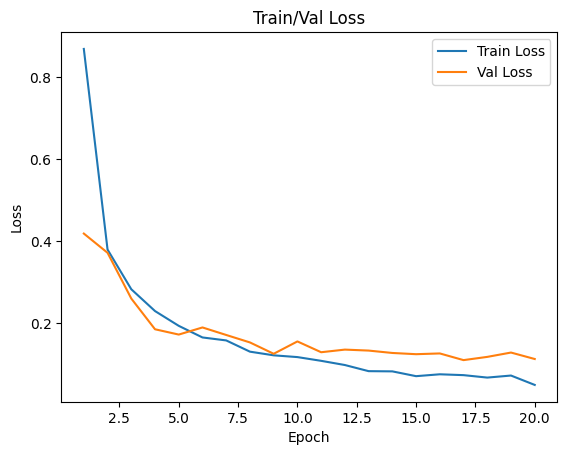

In [17]:
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train/Val Loss')
plt.show()

In [18]:
test_df = pd.read_csv("data/test.csv", low_memory=False)
test_df

,id,sbj_id,sensor_location,x_axis,y_axis,z_axis
0,0,22,right_arm,"[0.2428425714285714, 0.2134530714285714, 0.174...","[0.8463437142857143, 0.854221738095238, 0.8428...","[-0.4574545714285714, -0.4578691904761905, -0...."
1,1,22,right_arm,"[0.6752909910531751, 0.4247757439107542, 0.715...","[-0.9366750995461923, -0.6223881559309377, -0....","[-0.6175092749440796, -0.5824192453686647, -0...."
2,2,23,right_arm,"[0.04528874289978267, 0.02636863686942854, -0....","[0.5794056316368844, 0.5853422923083632, 0.646...","[0.5778143538332879, 0.5922718075175648, 0.873..."
3,3,23,right_arm,"[-0.4294609406487871, -0.6656510068112931, -0....","[-0.147632980836954, -0.014413570611691117, -0...","[-1.0071089537700262, -0.8174943548296542, -0...."
4,4,23,right_arm,"[2.476312835574577, 1.6733647285880453, 1.7557...","[-0.5983137218068052, -0.10164738944146791, -0...","[-2.0541462483911856, -1.6842387016850981, -1...."
...,...,...,...,...,...,...
48931,48931,23,left_leg,"[1.0630785714285715, 1.0709205714285714, 0.933...","[0.1038264761904761, 0.1515437142857142, 0.190...","[0.4514348571428571, 0.4639102857142857, 0.422..."
48932,48932,25,left_leg,"[0.834704380952381, 0.9560397142857142, 0.7693...","[0.4938431904761905, -0.2392702857142856, -0.9...","[0.0447854047619047, -0.0320387142857142, -0.2..."
48933,48933,24,left_leg,"[1.060091142857143, 1.0703054285714286, 1.0746...","[0.0607051428571428, 0.0170856904761904, 0.008...","[-0.1507257142857143, -0.1675727857142857, -0...."
48934,48934,23,left_leg,"[-0.9559132857142858, -0.0778062857142857, -0....","[-0.5109039047619047, 2.9042674285714285, 0.89...","[0.1249424761904761, 0.2449837142857142, 0.542..."


In [68]:
pivot_df = test_df.pivot(index='id', columns='sensor_location', values=['x_axis','y_axis','z_axis'])
# Namen angleichen → {loc}_{axis} (ohne "_acc"-Suffix)
new_cols = []
for axis, loc in pivot_df.columns:
    axis_short = axis[0]  # x_axis -> x, y_axis -> y, z_axis -> z
    if loc.endswith('_acc'):
        col_name = f"{loc}_{axis_short}"
    else:
        col_name = f"{loc}_acc_{axis_short}"  # füge _acc hinzu, wenn im Train so benannt
    new_cols.append(col_name)
pivot_df.columns = new_cols
pivot_df = pivot_df.reset_index()
print("Spalten nach Pivot:", pivot_df.columns.tolist()[:10])

# Basismatrix mit allen Train-Sensor-Spalten (fehlende Sensoren = 0)
base_test = pd.DataFrame(0, index=pivot_df.index, columns=sensor_cols)
# Überschneidung füllen
for col in sensor_cols:
    if col in pivot_df.columns:
        base_test[col] = pivot_df[col]

# Skalierung
base_test[sensor_cols] = scaler.transform(base_test[sensor_cols])
base_test['id'] = pivot_df['id']

# Sequenzen erzeugen
values = base_test[sensor_cols].values
ids = base_test['id'].values
sequences, seq_ids = [], []
for i in range(0, len(base_test) - WINDOW_SIZE + 1, STEP_SIZE):
    sequences.append(values[i:i+WINDOW_SIZE])
    seq_ids.append(ids[i])
X_test = torch.tensor(np.array(sequences), dtype=torch.float32).to(device)
print(f"X_test shape: {X_test.shape}")
data_test = pivot_df.dropna(subset=test_cols).reset_index(drop=True)

# Skalierung
data_test[test_cols] = scaler.transform(data_test[test_cols])

# Sequenzen erzeugen anhand fortlaufender id-Reihenfolge
# Hier nutzen wir den index in pivot_df als Zeit
values = data_test[test_cols].values
ids = data_test['id'].values
sequences, seq_ids = [], []
for i in range(0, len(data_test) - WINDOW_SIZE + 1, STEP_SIZE):
    seq = values[i:i+WINDOW_SIZE]
    sequences.append(seq)
    seq_ids.append(ids[i])
X_test = torch.tensor(np.array(sequences), dtype=torch.float32).to(device)
print(f"X_test shape: {X_test.shape}")

# Vorhersagen
model.eval()
preds = []
with torch.no_grad():
    for xb in DataLoader(X_test, batch_size=batch_size):
        logits = model(xb)
        preds.extend(logits.argmax(dim=1).cpu().numpy())


Spalten nach Pivot: ['id', 'left_arm_acc_x', 'left_leg_acc_x', 'right_arm_acc_x', 'right_leg_acc_x', 'left_arm_acc_y', 'left_leg_acc_y', 'right_arm_acc_y', 'right_leg_acc_y', 'left_arm_acc_z']


ValueError: could not convert string to float: '[0.2428425714285714, 0.2134530714285714, 0.1747093333333333, 0.1359561904761904, 0.1021450476190476, 0.0631573904761904, 0.0145962285714285, -0.0213671428571428, -0.0469919047619047, -0.0532688571428571, -0.0545326666666666, -0.0618505714285714, -0.0740160571428571, -0.0881772761904761, -0.0990204761904762, -0.1060097142857142, -0.1125049523809523, -0.1229300952380952, -0.1404117142857143, -0.1615804047619047, -0.1806195238095238, -0.198969619047619, -0.2177044761904762, -0.2330745904761904, -0.2477791, -0.2702355639097744, -0.2983505952380952, -0.3108898095238095, -0.3175154285714285, -0.3215467357142857, -0.3242848595238095, -0.3226944999999999, -0.3278828571428571, -0.3458519047619047, -0.3573982380952381, -0.3593672857142856, -0.3694402607142857, -0.3912872392857143, -0.4195397142857143, -0.4486532142857143, -0.4729640476190476, -0.481834225, -0.4717354416666667, -0.458918, -0.4592537142857142, -0.4719035714285714, -0.4851108571428571, -0.4967704, -0.5149714095238095, -0.5400368095238095]'

In [23]:
WINDOW_SIZE = 50
STEP_SIZE = 25
for i, df in enumerate([right_arm_df, left_arm_df, left_leg_df, right_leg_df]):
    all_X, all_y = [], []
    for subj in df['subject'].unique():
        df_sub = df[df['subject'] == subj].reset_index(drop=True)
        X_sub, y_sub = create_sequences(df_sub, [c for c in df.columns if c not in ['sbj_id', 'subject', 'label', 'label_code']], 'label_code', WINDOW_SIZE, STEP_SIZE)
        all_X.append(X_sub)
        all_y.append(y_sub)
    X = np.vstack(all_X)
    y = np.hstack(all_y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    # Train/Test Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    torch.manual_seed(42)
    batch_size = 64
    train_loader = DataLoader(SensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(SensorDataset(X_val, y_val), batch_size=batch_size)

    d = 3
    num_classes = 19#len(set(y))
    model = DeepConvLSTM(d, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    EPOCHS = 20
    train_losses, val_losses = [], []
    for epoch in range(1, EPOCHS+1):
        model.train()
        train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, yb)
            loss.backward(); optimizer.step()
            train_loss += loss.item()*Xb.size(0)
        train_losses.append(train_loss/len(train_loader.dataset))

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb)
                val_loss += criterion(preds, yb).item()*Xb.size(0)
                correct += (preds.argmax(1)==yb).sum().item()
        val_losses.append(val_loss/len(val_loader.dataset))
        print(f"Epoch {epoch}/{EPOCHS} - Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}, Acc: {correct/len(val_loader.dataset):.4f}")
    torch.save(model, f"models/DeepConvLSTM/{i}.pt")





X shape: (82157, 50, 3), y shape: (82157,)
Epoch 1/20 - Train: 1.3322, Val: 1.0470, Acc: 0.6400
Epoch 2/20 - Train: 0.9855, Val: 0.9108, Acc: 0.6876
Epoch 3/20 - Train: 0.8509, Val: 0.8160, Acc: 0.7171
Epoch 4/20 - Train: 0.7631, Val: 0.7546, Acc: 0.7381
Epoch 5/20 - Train: 0.6969, Val: 0.7081, Acc: 0.7554
Epoch 6/20 - Train: 0.6440, Val: 0.6674, Acc: 0.7676
Epoch 7/20 - Train: 0.5988, Val: 0.6735, Acc: 0.7682
Epoch 8/20 - Train: 0.5607, Val: 0.6241, Acc: 0.7838
Epoch 9/20 - Train: 0.5297, Val: 0.6151, Acc: 0.7820
Epoch 10/20 - Train: 0.4950, Val: 0.6060, Acc: 0.7901
Epoch 11/20 - Train: 0.4659, Val: 0.5813, Acc: 0.8011
Epoch 12/20 - Train: 0.4396, Val: 0.5787, Acc: 0.8021
Epoch 13/20 - Train: 0.4164, Val: 0.6025, Acc: 0.7975
Epoch 14/20 - Train: 0.3910, Val: 0.5778, Acc: 0.8093
Epoch 15/20 - Train: 0.3716, Val: 0.5669, Acc: 0.8160
Epoch 16/20 - Train: 0.3483, Val: 0.5912, Acc: 0.8098
Epoch 17/20 - Train: 0.3324, Val: 0.5896, Acc: 0.8101
Epoch 18/20 - Train: 0.3133, Val: 0.6076, Acc: 0